In [1]:
%load_ext autoreload
%autoreload 2

import random
import torch
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt

from scipy.stats import norm, skewnorm

In [2]:
seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

[ Using Seed :  633  ]


In [3]:
from koopman_probabilistic import KoopmanProb
from model_objs import NormalNLL

In [47]:
all_data = np.load("FPUTscipy.npy")

In [49]:
x = np.transpose(all_data[1::4])
x.shape

(200000, 10)

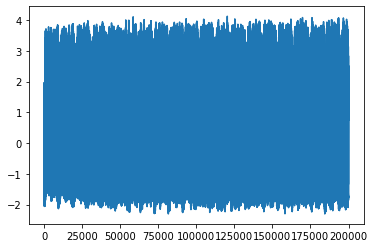

In [50]:
%matplotlib inline
plt.plot(x[:, -1])

In [51]:
x_original = x
mean = np.mean(x, axis=0)
rnge = np.max(x, axis=0) - np.min(x, axis=0)
x = (x - np.matlib.repmat(mean, x.shape[0], 1)) / np.matlib.repmat(rnge, x.shape[0], 1)
print("x", x.shape)

x (200000, 10)


In [55]:
data_name = f"FPUTscipy_{x.shape[1]}pts"

train_through = 30_000
train_start = 0
delay = 0
test_length = 20_000
x = x[train_start:]
predict_through = train_through + test_length + delay  
x = x[:predict_through]
xt = x[:train_through]

num_freqs = [4, 4]
num_fourier = 4
hard_code = [10200,]
mu_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}mu.npy"
sigma_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}sigma.npy"
print("x", x.shape)
print("xt", xt.shape)

x (50000, 10)
xt (30000, 10)


In [58]:
xt_ft = np.fft.fft(xt[:, 2], axis=0)
adj_xt_ft = (abs(xt_ft) + abs(np.flip(xt_ft))).reshape(xt_ft.size)  # reshape this
freqs = np.tile(np.fft.fftfreq(len(xt_ft)), xt.shape[1])  # repeat this 5 times
freqs

array([ 0.00000000e+00,  3.33333333e-05,  6.66666667e-05, ...,
       -1.00000000e-04, -6.66666667e-05, -3.33333333e-05])

In [59]:
best_omegas = np.zeros(num_fourier)
i = 0
num_found = 0
while num_found < num_fourier:
    amax = np.argpartition(-adj_xt_ft[:len(xt_ft) // 2], i)[i]  # ith biggest freq
    if freqs[amax] != 0 and all(abs(1 - best_omegas / freqs[amax]) > 0.1):
        best_omegas[num_found] = freqs[amax]
        num_found += 1
    i += 1

In [60]:
hard_code = list(1/best_omegas)
hard_code[-1] = 10200

In [61]:
model = NormalNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=512, n2=128)
k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)

In [62]:
k.find_fourier_omegas(xt, hard_code=hard_code)

fourier periods: tensor([   77.3196,    38.6598,    25.7511, 10200.0000], dtype=torch.float64)


tensor([0.0813, 0.1625, 0.2440, 0.0006], dtype=torch.float64)

In [102]:
k.fit(xt, iterations=500, verbose=True, cutoff=0, weight_decay=1e-3, lr_theta=1e-4, lr_omega=0);

Iteration  0
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -1.8667499402636496
Iteration  1
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -1.867329106616389
Iteration  2
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -1.867916099075362
Iteration  3
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.

Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -1.8824203892419575
Iteration  28
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -1.8830842735562494
Iteration  29
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -1.8836230575456183
Iteration  30
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0

Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -1.8981881412237032
Iteration  55
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -1.898757953644368
Iteration  56
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -1.8993139816990425
Iteration  57
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.00

Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -1.9145510704518474
Iteration  82
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -1.9152756640425228
Iteration  83
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -1.9158996414525256
Iteration  84
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0

Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -1.9327202774621886
Iteration  109
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -1.933376156253498
Iteration  110
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -1.9339695333669473
Iteration  111
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200

Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -1.9514235719391186
Iteration  136
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -1.9521603109723886
Iteration  137
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -1.9529107108971693
Iteration  138
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 1020

Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -1.9697157637123175
Iteration  163
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -1.9702787752045103
Iteration  164
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -1.9710810803037955
Iteration  165
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 1020

Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -1.98617133905585
Iteration  190
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -1.9868883917714406
Iteration  191
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -1.9873121042831405
Iteration  192
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.

Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -2.0011267018140506
Iteration  217
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -2.0016204442216736
Iteration  218
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -2.0025159202829026
Iteration  219
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 1020

Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -2.0148948822082753
Iteration  244
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -2.015414669881826
Iteration  245
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -2.015830792723692
Iteration  246
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.

Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -2.0277350537095136
Iteration  271
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -2.028334116939773
Iteration  272
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -2.028717257040734
Iteration  273
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.

Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -2.0398711506407228
Iteration  298
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -2.0402979035368594
Iteration  299
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -2.0406215309394002
Iteration  300
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 1020

Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -2.0511516203955984
Iteration  325
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -2.05145147483863
Iteration  326
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -2.051916062231415
Iteration  327
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0

Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -2.0616015114154704
Iteration  352
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -2.0617924506202483
Iteration  353
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -2.062267419681266
Iteration  354
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200

Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -2.071185179364206
Iteration  379
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -2.071753075500365
Iteration  380
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -2.0718661640344305
Iteration  381
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.

Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -2.080445009072818
Iteration  406
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -2.080902179824899
Iteration  407
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000], grad_fn=<MulBackward0>)
Loss:  -2.081148127703575
Iteration  408
tensor([   77.3196,    38.6598,    25.7511, 10200.0000,    77.3196,    38.6598,
           25.7511, 10200.0000])
Setting periods to tensor([   77.3196,    38.6598,    25.7511, 10200.0

KeyboardInterrupt: 

In [103]:
params = k.predict(predict_through)
mu_hat, sigma_hat = params
print(np.max(mu_hat))
mu_hat = rnge * mu_hat + mean
sigma_hat *= rnge
print(np.max(mu_hat))
params = mu_hat, sigma_hat
# np.save(mu_file, mu_hat)
# np.save(sigma_file, sigma_hat)

0.53135675
12.981349427952306


<IPython.core.display.Javascript object>


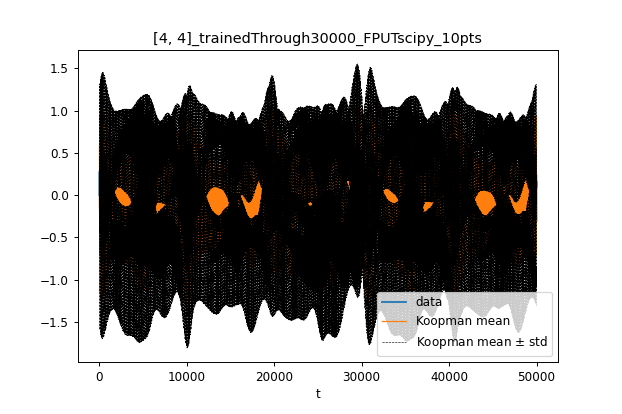

<IPython.core.display.Javascript object>


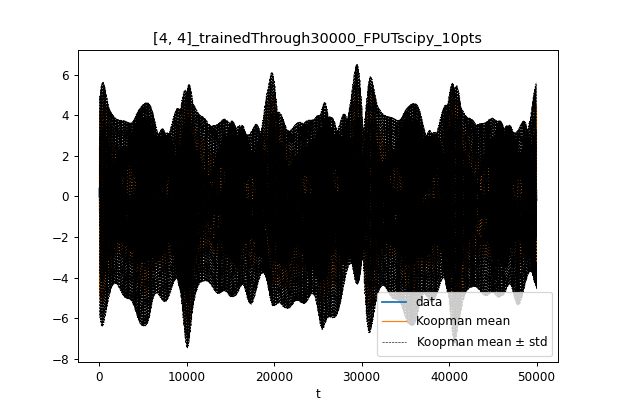

<IPython.core.display.Javascript object>


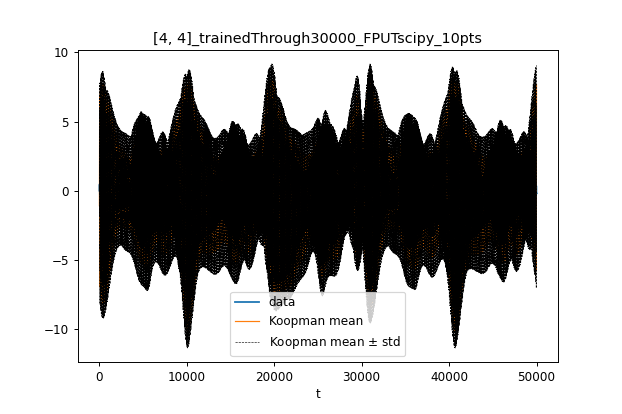

<IPython.core.display.Javascript object>


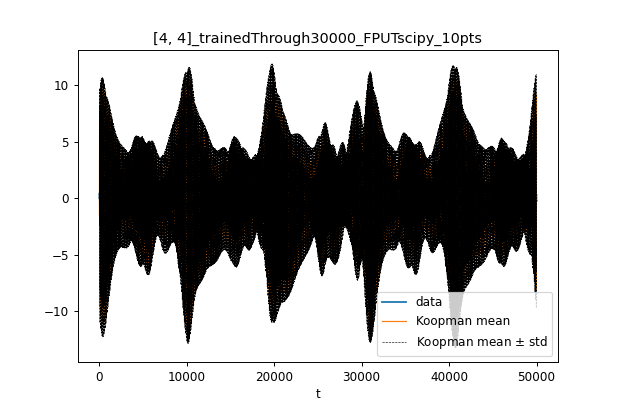

<IPython.core.display.Javascript object>


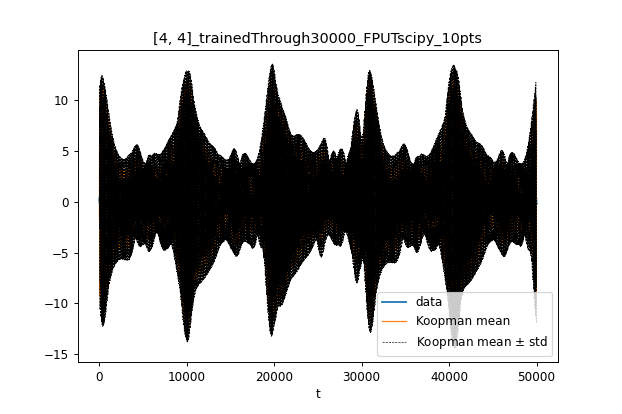

<IPython.core.display.Javascript object>


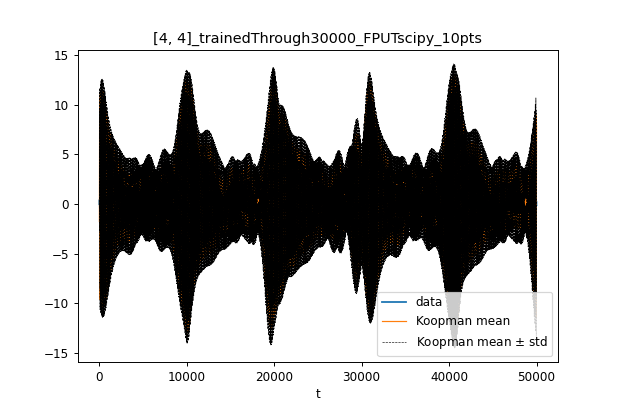

<IPython.core.display.Javascript object>


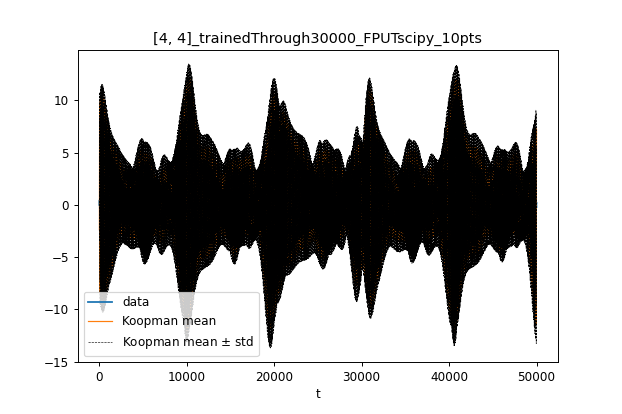

<IPython.core.display.Javascript object>


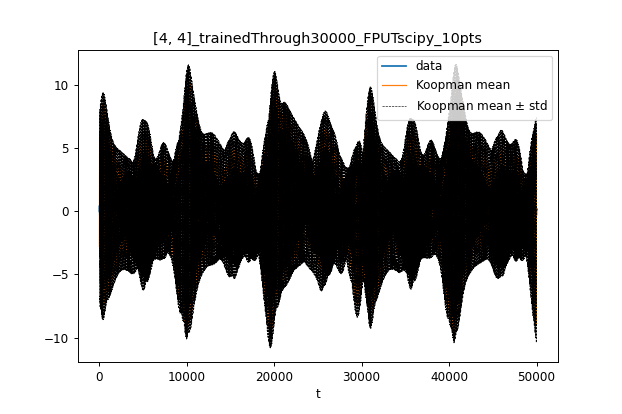

<IPython.core.display.Javascript object>


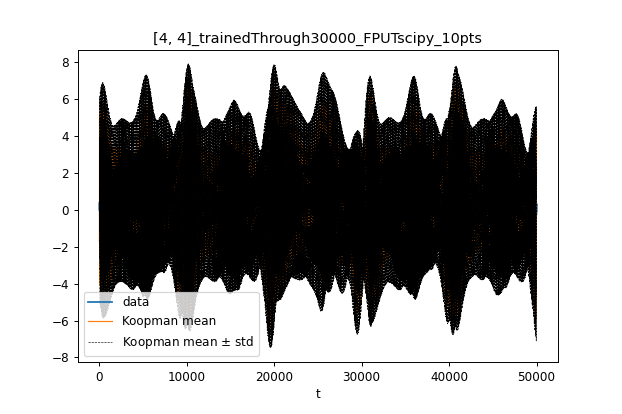

<IPython.core.display.Javascript object>


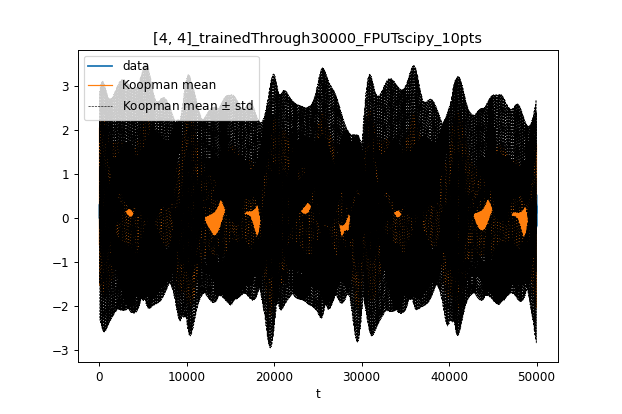

In [104]:
%matplotlib notebook

mean_hat = model.mean(params)
std_hat = model.std(params)
for dim in range(xt.shape[1]):
    plt.figure()
    # plt.scatter(np.arange(-slc), x[slc:], label="data")
    plt.plot(x[:predict_through, dim], label="data")
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
#     plt.plot(a_hat[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
#     plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")

    # plt.plot(mu_vec[slc:], label="real mu")
    # plt.plot(mu_hat[slc:, 0], label="koopman mu")
    # plt.legend()
    # plt.show()
    #
    # plt.plot(sigma_vec[slc:], label="real sigma")
    #     plt.plot(3*sigma_hat[:, dim], label="koopman $3\sigma$", linewidth=0.7)
    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

In [96]:
# plt.figure()
# plt.plot(np.arange(len(oldx), len(oldx) + len(x_original)), x_original, label="2021")
# plt.plot(oldx, label="demand 2005-15")
# plt.legend()
# plt.show()

In [30]:
print("actual overall mean:", 0, " predicted mean:", np.mean(mean_hat[:train_through]))

actual overall mean: 0  predicted mean: 0.009649986


In [98]:
"mean of a_hat", np.mean(a_hat), "std of a_hat", np.std(a_hat)

('mean of a_hat', 2.3238902, 'std of a_hat', 0.4065727)

In [14]:
def normal_pdf(mu, sigma, x):
    return np.exp(-(x - mu)**2 / (2 * sigma**2))/((2 * np.pi * sigma**2)**0.5)

In [21]:
z_scores = ((x[:train_through] - mean_hat[:train_through]) / std_hat[:train_through])
# z_scores = ((x[train_through:predict_through] - mean_hat[train_through:]) / std_hat[train_through:])[:8760, 0]
# z_scores /= np.std(z_scores)
z_hist, bin_edges = np.histogram(z_scores, bins=40, density=True)
z_axis = (bin_edges[1:] + bin_edges[:-1]) / 2

In [22]:
print(np.std(z_scores))
np.mean(z_scores)

0.9739735982666695


-0.10160407016708353

<IPython.core.display.Javascript object>


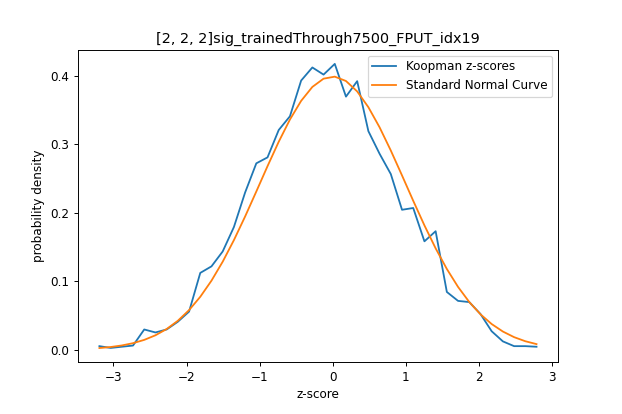

In [23]:
plt.figure()
plt.plot(z_axis, z_hist, label="Koopman z-scores")
plt.plot(z_axis, normal_pdf(0, 1, z_axis), label="Standard Normal Curve")
plt.title(f"{num_freqs}sig_trainedThrough{train_through}_" + data_name)
plt.xlabel("z-score")
plt.ylabel("probability density")
plt.legend()

In [81]:
mu_hat -= np.mean(mean_hat[:train_through])

# Watch with pygame

In [79]:
import pygame

In [86]:
n_pts = mean_hat.shape[1]
n_pts

10

In [87]:
x_max = 500
x_coords = np.linspace(10, x_max - 10, 40, dtype=np.uint16)[1::40 // n_pts]
x_coords

array([ 22,  71, 120, 170, 219, 268, 317, 366, 416, 465], dtype=uint16)

In [108]:
w = pygame.display.set_mode((x_max, 300))
running = True
t = 49000
T = len(mean_hat)
vscale = 10
while running:
    
    w.fill((255, 255, 255))
    
    points = []
    lower_bound = []
    upper_bound = []
    for i in range(n_pts):
        points.append((x_coords[i], int(150 - vscale * mean_hat[t, i])))
        lower_bound.append((x_coords[i], int(150 - vscale * (mean_hat[t, i] - 2 * std_hat[t, i]))))
        upper_bound.append((x_coords[i], int(150 - vscale * (mean_hat[t, i] + 2 * std_hat[t, i]))))
    
    bounds = lower_bound.copy()
    bounds.extend(upper_bound[::-1])
    pygame.draw.polygon(w, (255,128,0), bounds)
    
    for i in range(n_pts):
#         pygame.draw.line(w, (255,128,0), points[i], points[i+1], 3)
        pygame.draw.circle(w, (0,0,255), (x_coords[i], int(150 - vscale * x_original[t, i])), 3)
    pygame.draw.circle(w, (255,255,255 * (1 - t / T)), (20, 20), 10)
    
    pygame.display.flip()

    for ev in pygame.event.get():
        if ev.type == pygame.QUIT:
            pygame.quit()
            running = False
    
    pygame.time.wait(10)
    t = (t + 1) % T
    

In [94]:
pygame.quit()